# Data Preprocessing and Exploratory Analysis


This notebook documents the essential normalization, quality assessment and general preprocessing and analysis steps of the created dataframe.

Initial ideas consist of:

 - Hounsfield Units Manual Normalization
 - Class Imbalance Identification (maintain data ratio on augmentation or aim for 50/50?)
 - Investigate new, possibly more meaningful metrics
 - General EDA

The core objective of this notebook is to build a clean, augmented dataframe and export it to a `.pkl` file. The file will be used to compare augmentation performance. I assume this `.ipynb` file can possibly be reused (needs only changes on solutions due to observed issues) with the 3d dataset.

In [ ]:
# Relevant imports

import os
import pandas as pd
import pickle
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Pulling dataframe 

# df_fibrosis = pd.read_pickle(r'D:\\Rafa\\A1Uni\\2semestre\\Estágio\\fibrosis_data.pkl')

df_fibrosis = pd.read_pickle(r'C:\\Users\\hasht\Desktop\\fibrosis_data.pkl')
df_fibrosis.head(10)

,SliceID,SliceData,Class
0,CT-0002-0001.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
1,CT-0002-0002.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
2,CT-0002-0003.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
3,CT-0002-0004.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
4,CT-0002-0005.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
5,CT-0002-0006.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
6,CT-0002-0007.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",1
7,CT-0002-0008.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
8,CT-0002-0009.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0
9,CT-0002-0010.dcm,"[[-2000.0, -2000.0, -2000.0, -2000.0, -2000.0,...",0


# Preliminary Analysis

I won't be performing any type of specific statystical analysis here, since features will be derived by CNN. Instead, I will be focusing on normalization and augmentation, with the intent of enhancing algortihm performance.

In [21]:
# General overview
print("\nGeneral overview:")
df_fibrosis.info()


General overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2221 entries, 0 to 2220
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SliceID    2221 non-null   object
 1   SliceData  2221 non-null   object
 2   Class      2221 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.2+ KB


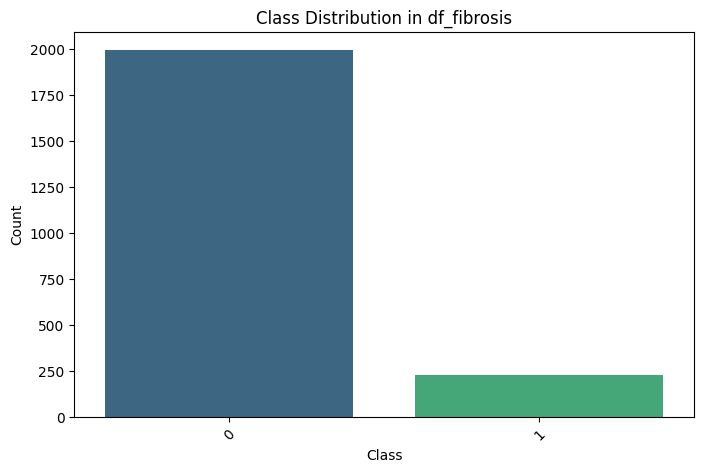

Class
0    89.734354
1    10.265646
Name: count, dtype: float64


In [31]:
# Plots class counts
plt.figure(figsize=(8, 5))
sns.countplot(data=df_fibrosis, x='Class', hue="Class", palette='viridis', legend=False)

plt.title('Class Distribution in df_fibrosis')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


# Displays imbalance
class_counts, total_samples = df_fibrosis['Class'].value_counts(), len(df_fibrosis)
print((class_counts / total_samples) * 100)

After identifying the drastic class imbalance, I am faced with a dillema. I am already planning on applying data augmentation, so my options are:

 - **Equalizing or approximating proportions:** this would provide the model with roughly the same ammount of `fibrosis` vs `not_fibrosis` data. The issue is that I would be artifically affecting the natural proportion of fibrosis found in the study's population, as well as introducing a much higher portion of augmented data as `fibrosis` slices when compared to `not_fibrosis`.

 - **Keeping proportions:** this would ensure the correct representation of the study's population, maintaining potentially relevant data relationships. However, the model could be biased towards the majority class (`not_fibrosis`), or be much better at its detection when compared to `fibrosis`, due to the significantly reduced number of examples.


In order to respect data integrity, I decided to apply augmentation while keeping proportions. As a way to correctly evaluate performance, weighted metrics will be employed after model training.

## Normalization 




In order to apply **Hounsfield Unit** normalization, I will be using [Aadhav Vignesh's](https://www.kaggle.com/code/aadhavvignesh/lung-segmentation-by-marker-controlled-watershed#Hounsfield-Units) beautifully elaborated explanation of the concept:

Hounsfield Units (HU) are a standardized measure of radiodensity used in **computed tomography (CT) scans**. They are derived from a **linear transformation** of the attenuation coefficients, allowing for consistent interpretation across different scans.  

<div style="width: 35%; margin: 0 auto; text-align: center;">
    <img src="../z_imgs/hu_units.png" alt="Hounsfield Units">
</div>



HU values can be calculated from a **DICOM image’s pixel data** using the formula:  


<div style="text-align: center;">
    HU = (m \times P) + b 
</div>


where:  
- **m** = RescaleSlope (DICOM attribute)  
- **b** = RescaleIntercept (DICOM attribute)  
- **P** = Pixel Array  

This transformation ensures that CT numbers are expressed in a consistent and meaningful way.

The interval, [-1000, 1000], was also suggested by tutors.

In [ ]:
def norm_hu(df_original):
    # Prevents destructive behaviour, preserves underlying data structures
    df = df_original.copy(deep=True)

    # Iterate slices
    for index, row in df.iterrows():
        image = row['SliceData']
        
        # Set out-of-scan pixels (typically -2000) to 0
        image[image == -2000] = 0
        
        # Get max and min values
        min_val, max_val = np.min(image), np.max(image)
        
        # Prevents / 0, scales to [-1000, 1000]
        if max_val != min_val: image = -1000 + (image - min_val) * (2000 / (max_val - min_val))           
        
        # Update dataframe
        df.at[index, 'SliceData'] = image.astype(np.float64)
    return df

Let's see how this process visually impacts the slice information:

In [36]:
def hu_check(df_fibrosis, folder, file):
    file_dir = os.path.join(folder, file)
    full_dir = os.path.join(root_dir, file_dir)

    # Read raw DICOM file
    dicom_data = pydicom.dcmread(full_dir)
    dicom_image = dicom_data.pixel_array  # Extract pixel array (NumPy)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Raw DICOM image
    axes[0].imshow(dicom_image, cmap='gray')
    axes[0].set_title("Original DICOM Image")
    axes[0].axis("off")

    # NumPy image
    if file in df_fibrosis["SliceID"].values:
        np_array = df_fibrosis[df_fibrosis["SliceID"] == file]["SliceData"].values[0]
    else:
        print(f"Warning: {file} not found in DataFrame")
        np_array = np.zeros_like(dicom_image)

    axes[1].imshow(np_array, cmap='gray')
    axes[1].set_title("NumPy Array Representation")
    axes[1].axis("off")

    plt.show()

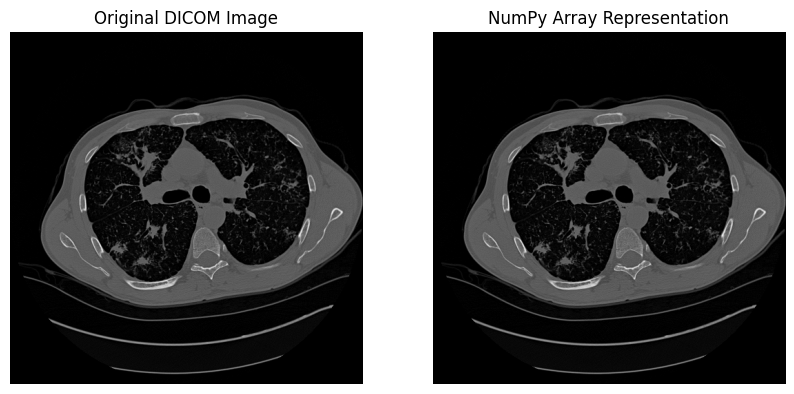

In [38]:
root_dir = 'C:\\Users\\hasht\\Desktop\\Cloned Repositories\\fibrosis_dataset\\ILD_DB_txtROIs'

df_processed = norm_hu(df_fibrosis)

hu_check(df_processed, '7', 'CT-7771-0012.dcm')

This is a type of visually non-destructive normalization, so there will be no noticeable plot differences. Nonetheless, numerically, the model will be able to handle data more efficiently.

In [ ]:
# Used to portray that values are, in fact, different

n = 5  
random_rows = df_processed.sample(n=n)
differences = []

for i, row in random_rows.iterrows():  
    diff = np.abs(row['SliceData'] - df_fibrosis.iloc[i]['SliceData'])
    max_diff = np.max(diff)
    
    if max_diff > 0:
        differences.append((i, max_diff, row['SliceID']))

for row, diff, slice_id in differences:
    print(f"Id: {slice_id}, diff: {diff}")


Id: CT-6135-0022.dcm, diff: 1819.0
Id: CT-2950-0005.dcm, diff: 1965.0001220703125
Id: CT-2336-0008.dcm, diff: 1858.9998779296875
Id: CT-0921-0015.dcm, diff: 1868.0
Id: CT-8929-0021.dcm, diff: 2531.0


## Augmentation Methods

# ADD CITATION

Choosing data augmentation methods can be challenging, especially when it is usually determined by the type, format and nature of the data in question. It's important that I choose implementations that will allow for the data to retain important details sufficiently well, while generating images that introduce uncertainty, noise and meaningful transformations.

This will most likely force the model to be more robust to generalization of data, as well as increase the number of training examples.

In order to choose the best augmentation methods, I decided to follow results obtained in ["Goceri, E. Medical image data augmentation: techniques, comparisons and interpretations. Artif Intell Rev 56, 12561–12605 (2023)"](https://doi.org/10.1007/s10462-023-10453-z), as the paper evaluates various performance metrics of different methods on a variety of medical image datasets, including lung CT scans.

Based on ammount of generated examples, as well as positive impact in classification, I have decided to explore:


 - **Translation + Shearing:** Could be destructive, in the sense that fibrosis region could be removed/hidden. On the other hand, since examples are created as independent and don't change the original slice data, that could be overlooked as long as AI classifies as not fibrosis if it can't see it. **10x data**.
 - **Translation + Shearing + Rotation:** Same as before, adds another layer of change due to rotation, could affect performance, improve genralization. However, I should be careful not to generate too many examples of the same slice. In order to solve that, I will create independent subsamples of my data in order to apply each method. **10x data**.
 - **Gaussian Noise:** Adds distortion that follows a subsample of the Gaussian Distribution. **3x data**.
 - **Gaussian Noise + Rotation:** Same as the previous topic, adds rotation for generalization purposes. **30x data**.